In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
from networkx import nx,  erdos_renyi_graph

from numpy import linalg as LA
import time
from tqdm import tqdm
import seaborn as sns
import random

## CLUSTERING ANALYSIS OF THE CRIMINAL NETWORKS 

The field of social network analysis has received increasing attention during the past decades and has been used to tackle a variety of research questions.In particular, social network
analysis are becoming an important component in studies of criminal networks and in criminal intelligence analysis. Rostami and Mondani's study contributes to strengthening social network analysis as a reliable tool for understanding and analyzing criminality and
criminal networks in Swedish street gang dataset. They figured out the gang’s organizational structure; one up to 2007 and
the other up to 2010[1]. 



Our aims are expleaning cluster structures and interactions between organization members.A study discuss the problem of detecting whether or not, in a
given network, there is a cluster of nodes which exhibit an “unusual behavior." 
 They observe a realization of this process and would like to tell whether all
the variables at the nodes have the same behavior, in the sense that they are all
sampled from a common distribution[2]. Aarias and Castro utilizes percolation for dedecting clusters[3]. We measue clustering coefficients to interpret relationships and utilize local and global efficiency to make sense of crime ring.




<img src="baba.jpg">

# 1. Crime Graph Datasets
We intestigate two criminal datasets which are called Montagna Meetings and Enron E-Mails. 

## Graph 1 (Montagna Meetings)
This dataset is based on police
traces of meeting that have taken place among different types of criminals. There are two known family in the figure. Turquoise nodes represent the members of the “Mistretta” family, while the “Batanesi” family is drawn with yellow nodes. Circled nodes are leaders and important persons for families. The green and purple circled nodes refer to bosses of Mafia families. Also, the white nodes are other people who are close to a family. The graph is weighted and undirected.

<img src="montagna_1.png">

Data and image are retrieved from: https://zenodo.org/record/3938818#.YBkbZugzaUk

## Graph 2 (Enron E-Mails)
Enron is a Energy commodity company based on United States. Fortune magazine had named Enron as the most innovative company in United States for 6 consecutive years. Enron was started in the year 1985. They were involved in many businesses such as Oil, Natural Gas, Electricity, Bandwidth, Paper and Video on Demand. Enron claimed that they have received 101 Billion as revenue during the year 2000, But shockingly went bankrupt on December 2, 2001[4]. This dataset was collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes). It contains data from about 150 users, mostly senior management of Enron, organized into folders. The corpus contains a total of about 0.5M messages. This data was originally made public, and posted to the web, by the Federal Energy Regulatory Commission during its investigation. In this network nodes are important employees in company and edges are interaction between them.

<img src="enron.png">

Data and image are retrieved from: http://networkrepository.com/ia-enron-only.php

In [2]:
# reading dataset
G1 = nx.read_edgelist("Montagna_meetings_edgelist.csv", nodetype=int, data=(("weight", float),))
G1 = nx.Graph(G1)

# seeting weights 1
# we wanted to analyse only existance of the interactions rather than the strength of them
for u,v,d in G1.edges(data=True):
    d['weight'] = 1

#creating adjecency matricies
G1_adj= nx.to_numpy_matrix(G1)

G2 = nx.read_edgelist("ia-enron-only.mtx", nodetype=int, data=(("weight", float),))
G2 = nx.Graph(G2)
G2_adj= nx.to_numpy_matrix(G2)

## 1.1. Network Adj Matrices

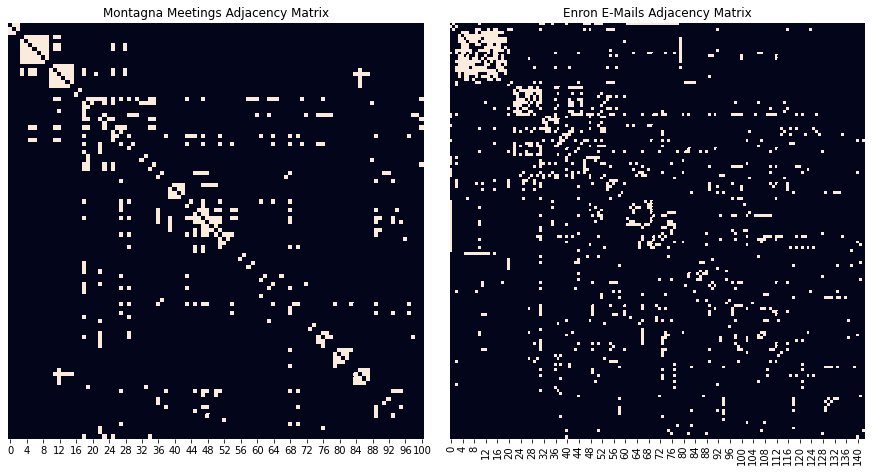

In [3]:
fig, axs = plt.subplots(1,2, figsize=(12, 16), constrained_layout=True)

axs[0].title.set_text("Montagna Meetings Adjacency Matrix")
sns.heatmap(G1_adj, cbar=False, yticklabels=False, cmap="rocket", ax=axs[0], square=True)

axs[1].title.set_text("Enron E-Mails Adjacency Matrix")
sns.heatmap(G2_adj, cbar=False, yticklabels=False, cmap="rocket", ax=axs[1], square=True)
plt.show()

## 1.2. Network Node Degree Distributions

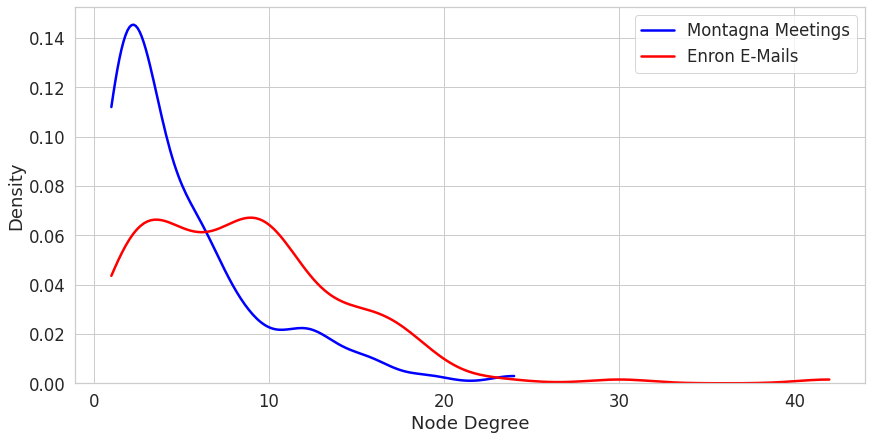

In [4]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

fig, ax = plt.subplots(1,1, figsize=(12, 6), constrained_layout=True)

G1_degrees = np.array(list(dict(G1.degree).values()))
G2_degrees = np.array(list(dict(G2.degree).values()))

## Generating kernel density estimations
sns.kdeplot(data=G1_degrees, label="Montagna Meetings", bw_method=0.3, cut=0, ax=ax, color="blue")
sns.kdeplot(data=G2_degrees, label="Enron E-Mails", bw_method=0.3, cut=0, ax=ax, color="red")

ax.set_ylabel("Density")
ax.set_xlabel("Node Degree")

ax.legend()
plt.show()

# 2. Concept: Clustering

## 2.1. Definition

In this study, triangular clustering concept is conducted to determine and analyze the clusters of crime related datasets. The first dataset is formed to scheme "Montagna Meetings" in Sicilian crime network. The second dataset is an e-mail interaction network between important employees involving in the scandal of Enron Corporation.

Intuitively, it can be concluded that crime networks should have some cluster and modular structure due to the nature of a formation of crime. If a particular group of people involving a crime has a greater interaction with each other, then there should be some cluster formation between them. For instance, a CEO of Enron Corporation had a greater communication with C level managers rather than with energy specialists of the company, or in a mafia family; there is more interaction between family members than other mafia families' members. 

### 2.1.1. Clustering Coefficient

Clustering coefficient of a vertex is a normalized property to analyze triangular clustering of a vertex. It is simply calculated as by dividing the total number of triangular edge connections which involves a vertex $v_i$) with the total number of edges of a vertex vertex $v_i$. Average clustering coefficient is the average of the sum of all clustering coefficients of vertices in a graph. Mathemetical definition will be given in section 2.2.

##### Example local clustering coefficient on an undirected graph: 
The local clustering coefficient of the green node is computed as the proportion of connections among its neighbours.

<img src="clustering.png">

Image: https://www.geeksforgeeks.org/clustering-coefficient-graph-theory/


## 2.2. Mathematical Definition

For unweighted graphs, the clustering of a node $u$ is the fraction of possible triangles through that node that exist,

$c_u = \frac{2 T(u)}{deg(u)(deg(u)-1)}$, where $T(u)$ is the number of triangles through node $u$ and $deg(u)$ is the degree of $u$.

A graph $G=(V,E)$ formally consists of a set of vertices $V$ and a set of edges $E$ between them. An edge $e_{ij}$ connects vertex $v_i$ with vertex $v_j$.

The [[Neighbourhood (graph theory)|neighbourhood]]  $ N_i $ for a vertex $v_i$ is defined as its immediately connected neighbours as follows:
$N_i = \{v_j : e_{ij} \in E \lor e_{ji} \in E\}.$

We define $k_i$ as the number of vertices, $|N_i|$, in the neighbourhood,$N_i$, of a vertex.

An undirected graph has the property that $e_{ij}$ and $e_{ji}$ are considered identical. Therefore, if a vertex $v_i$ has $k_i$ neighbours, $\frac{k_i(k_i-1)}{2}$ edges could exist among the vertices within the neighbourhood. Thus, the '''local clustering coefficient for undirected graphs''' can be defined as : $C_i = \frac{2|\{e_{jk}: v_j,v_k \in N_i, e_{jk} \in E\}|}{k_i(k_i-1)}.$

Let $\lambda_G(v)$ be the number of triangles on $v \in V(G)$ for undirected graph $G$. That is, $\lambda_G(v)$ is the number of subgraphs of $G$ with 3 edges and 3 vertices, one of which is $v$. Let $\tau_G(v)$ be the number of triples on $v \in G$. That is, $\tau_G(v)$ is the number of subgraphs (not necessarily induced) with 2 edges and 3 vertices, one of which is $v$ and such that $v$ is incident to both edges. Then we can also define the clustering coefficient as:

$C_i = \frac{\lambda_G(v)}{\tau_G(v)}.$

It is simple to show that the two preceding definitions are the same, since:

$\tau_G(v) = C({k_i},2) = \frac{1}{2}k_i(k_i-1).$

These measures are 1 if every neighbour connected to $v_i$ is also connected to every other vertex within the neighbourhood, and 0 if no vertex that is connected to $v_i$ connects to any other vertex that is connected to $v_i$.

Since any graph is fully specified by its adjacency matrix ''A'', the local clustering coefficient for a simple undirected graph can be expressed in terms of ''A'':

$
C_i=\frac{1}{k_i(k_i-1)}\sum_{j,k} A_{ij}A_{jk}A_{ki}
$

where:

$
k_i=\sum_j A_{ij}
$

and ''C<sub>i</sub>''=0 when ''k<sub>i</sub>'' is zero or one. In the above expression, the numerator counts twice the number of complete triangles that vertex ''i'' is involved in. In the denominator, ''k<sub>i</sub><sup>2</sup>'' counts the number of edge pairs that vertex ''i'' is involved in plus the number of single edges traversed twice. ''k<sub>i</sub>'' is the number of edges connected to vertex i, and subtracting ''k<sub>i</sub>'' then removes the latter, leaving only a set of edge pairs that could conceivably be connected into triangles. For every such edge pair, there will be another edge pair which could form the same triangle, so the denominator counts twice the number of conceivable triangles that vertex ''i'' could be involved in.





### 2.2. Execution on Small Graphs

Nodes with higher clustering coefficient are represented with darker colors.

In [5]:
# Generating sample small graph with Erös-Renyi algorithm
small_G = nx.erdos_renyi_graph(25, 0.2, seed=1773, directed=False)
clustering_coeffs = np.minimum(np.array(list(nx.clustering(small_G).values()))*5, 1)

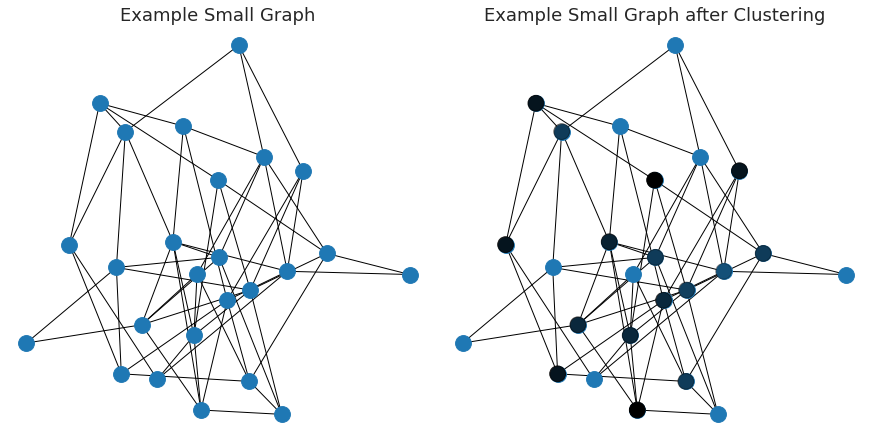

In [6]:
fig, axs = plt.subplots(1,2, figsize=(12, 6), constrained_layout=True)

nodePos = nx.spring_layout(small_G, seed=1773)

axs[0].title.set_text("Example Small Graph")
axs[1].title.set_text("Example Small Graph after Clustering")
nx.draw(small_G, node_size=250, ax=axs[0], pos=nodePos) 

nx.draw(small_G, node_size=250, ax=axs[1], pos=nodePos)
nx.draw_networkx_nodes(small_G, node_size=250, ax=axs[1], pos=nodePos, alpha = clustering_coeffs, node_color="black")

plt.show()

# 3. R-Space

## 3.1. Metrics


### 3.1.1. Dimension 2: Global Efficiency:
A graph's global efficiency is the reciprocal of the harmonic mean of its path lengths:

$
E(G) = \frac{1}{n(n-1)} \sum_{i \neq j \in G} \frac{1}{l(i,j)} 
$

### 3.1.2. Dimension 1: Local Efficiency


The efficiency of a pair of nodes in a graph is the multiplicative inverse of the shortest path distance between the nodes. The local efficiency of a node in the graph is the average global efficiency of the subgraph induced by the neighbors of the node. the '''local efficiency''' of a network is defined as:

$
E(G) = \frac{1}{n_{g_i}(n_{g_i}-1)} \sum_{i \neq j \in G} \frac{1}{l(i,j)} 
$

### 3.1.3. Relation to Explore

Global and local efficiency values give information flow efficiency from node i to j in a general or sub graph of a network. Paths between vertices of non-clustered graphs are globally shorter, but locally longer. Therefore, it is expected to reach high local efficiency but comperatively low global efficiency in more clustered graphs. 

Furthermore, by using the local and global efficiency metrics, we investigate the core-periphery structure of a network. More clustered networks has high interaction between local groups, and as a result, high local efficiency. Hence, if a network is formed by core-peripheral groups, it is expected to see high local efficiency. 

## 3.2. - 3.3.  Simulating Random Graphs w/ Maslov-Sneppen

Random synthetic graphs are simulated by using Maslov-Sneppen algorithm. Maslov-Sneppen algorithm rewires (changes the locations of the edges) all the nodes in the graph while preserving the number of nodes and edges, in addition to the degree sequence and approximate node strength (weighted degree) distributions.

Some of its known properties are:
- All the node degrees are being preserved.
- Node degree distribution is preserved.
- It can be used to identify the graph's important non-random topological patterns.

In [7]:
# Setting the Maslov-Sneppen randomization seeds

graph_count_G1 = 100
graph_count_G2 = 100

seeds_for_maslov1 = range(1773, 1773+graph_count_G1)
seeds_for_maslov2 = range(1773, 1773+graph_count_G2)

In [8]:
G1_syn = []

# Generating the Graph-1 variants

for i in tqdm(range(graph_count_G1)):
    random_graph = nx.random_reference(G1, niter=1, connectivity=True, seed=seeds_for_maslov1[i])
    G1_syn.append(random_graph)

100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


In [9]:
G2_syn = []

# Generating the Graph-2 variants

for i in tqdm(range(graph_count_G2)):
    random_graph = nx.random_reference(G2, niter=1, connectivity=True, seed=seeds_for_maslov2[i])
    G2_syn.append(random_graph)

100%|██████████| 100/100 [04:19<00:00,  2.60s/it]


## Calculating Graph Properties

In [10]:
# For simulated graphs

G1_x_1 = []
G1_y_1 = []

G2_x_2 = []
G2_y_2 = []

for random_graph in tqdm(G1_syn): 
    G1_x_1.append(nx.local_efficiency(random_graph))
    G1_y_1.append(nx.global_efficiency(random_graph))

for random_graph in tqdm(G2_syn):
    G2_x_2.append(nx.local_efficiency(random_graph))
    G2_y_2.append(nx.global_efficiency(random_graph))

100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


In [11]:
# For anchors

G1_anchor_x = [nx.local_efficiency(G1)]
G1_anchor_y = [nx.global_efficiency(G1)]

G2_anchor_x = [nx.local_efficiency(G2)]
G2_anchor_y = [nx.global_efficiency(G2)]

## 3.4. Degree Distributions
### 3.4.1. Montagna Meetings Node Degree Distribution

In [12]:
## To prevent duplicate legend labels
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

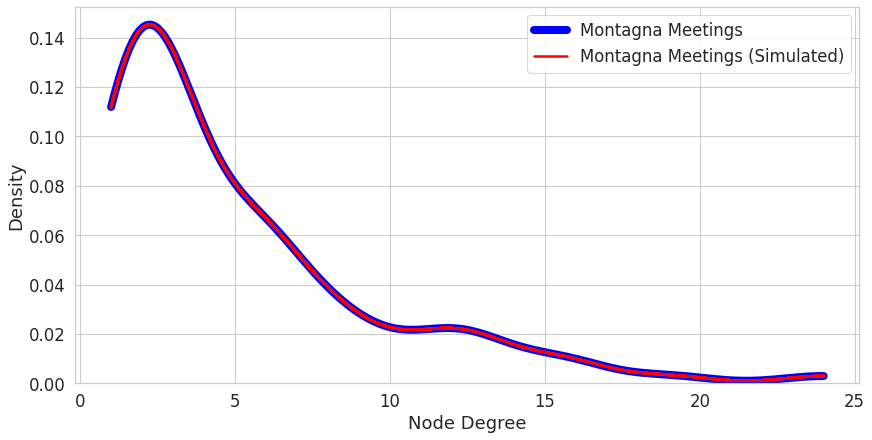

In [13]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

fig, ax = plt.subplots(1,1, figsize=(12, 6), constrained_layout=True)

G1_degrees = np.array(list(dict(G1.degree).values()))

sns.kdeplot(data=G1_degrees, label="Montagna Meetings", bw_method=0.3, cut=0, ax=ax, linewidth=8, color='blue')

for simG in G1_syn:
    G1_syn_degrees = np.array(list(dict(simG.degree).values()))
    sns.kdeplot(data=G1_syn_degrees, label="Montagna Meetings (Simulated)", bw_method=0.3, cut=0, ax=ax, color='red')

ax.set_ylabel("Density")
ax.set_xlabel("Node Degree")

ax.legend()
legend_without_duplicate_labels(ax)

plt.show()

As it is expected from Maslov-Sneppen algorithm, node degree distribution of simulated and based graphs is the same.

### 3.4.2. Enron E-Mails Node Degree Distribution

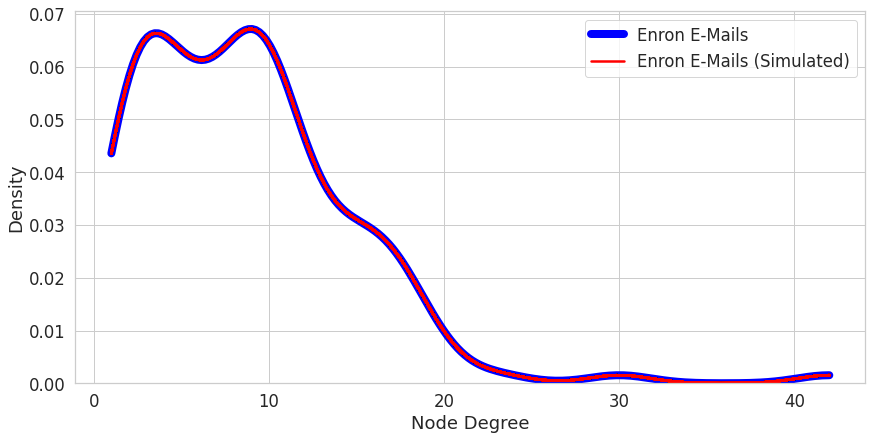

In [14]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

fig, ax = plt.subplots(1,1, figsize=(12, 6), constrained_layout=True)

G2_degrees = np.array(list(dict(G2.degree).values()))

sns.kdeplot(data=G2_degrees, label="Enron E-Mails", bw_method=0.3, cut=0, ax=ax, linewidth=8, color='blue')

for simG in G2_syn:
    G2_syn_degrees = np.array(list(dict(simG.degree).values()))
    sns.kdeplot(data=G2_syn_degrees, label="Enron E-Mails (Simulated)", bw_method=0.3, cut=0, ax=ax, color='red')

ax.set_ylabel("Density")
ax.set_xlabel("Node Degree")

ax.legend()
legend_without_duplicate_labels(ax)

plt.show()

As it is expected from Maslov-Sneppen algorithm, node degree distribution of simulated and based graphs is the same.

## 3.5. R Space Plot

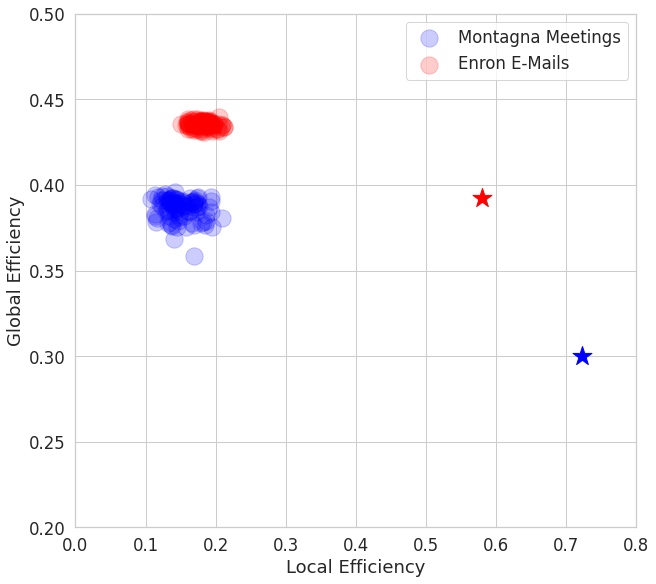

In [15]:
fig, ax = plt.subplots(figsize=(9, 8), constrained_layout=True)

ax.set_xlim(0,0.8)
ax.set_ylim(0.2,0.5)


ax.scatter(G1_x_1, G1_y_1, s=300, c="blue", alpha=0.2, label="Montagna Meetings")
ax.scatter(G1_anchor_x, G1_anchor_y, s=400, marker="*", c="blue")

ax.scatter(G2_x_2, G2_y_2, s=300, c="red", alpha=0.2, label="Enron E-Mails")
ax.scatter(G2_anchor_x, G2_anchor_y, s=400, marker="*", c="red")

ax.set_xlabel("Local Efficiency")
ax.set_ylabel("Global Efficiency")

ax.legend()
plt.show()


# 4. Result Interpretation & Discussions

- Maslov-Sneppen algorithm keeps the node degree distribution of a graph constant, yet it does not preserve the topology of original anchor graph. Hence, local efficiencies of both crime related graphs are higher than the efficiencies of randomly generated graphs. 
- Since clusters are broken by rewiring process of Maslov-Sneppen algorithm, global efficiency of randomly generated graphs are higher than the efficiencies of original graphs. 
- Even if simulated graphs are located very close to each other; original graphs ,due to their topological differences, are located far from the simulated graphs in R space. 

## 4.1. Visualizing Original and Simulated Graphs

We hereby show the adjadency matrices of both 

In [16]:
EG_G1 = []
EL_G1 = []

EG_1 = str(np.round(nx.global_efficiency(G1), 2))
EL_1 = str(np.round(nx.local_efficiency(G1), 2))
EG_G1.append(EG_1)
EL_G1.append(EL_1)

for i in range(3):
    EG_sim = str(np.round(nx.global_efficiency(G1_syn[i]), 2))
    EL_sim = str(np.round(nx.local_efficiency(G1_syn[i]), 2))
    
    EG_G1.append(EG_sim)
    EL_G1.append(EL_sim)

In [17]:
EG_G2 = []
EL_G2 = []

EG_2 = str(np.round(nx.global_efficiency(G2), 2))
EL_2 = str(np.round(nx.local_efficiency(G2), 2))
EG_G2.append(EG_2)
EL_G2.append(EL_2)

for i in range(3):
    EG_sim = str(np.round(nx.global_efficiency(G2_syn[i]), 2))
    EL_sim = str(np.round(nx.local_efficiency(G2_syn[i]), 2))
    
    EG_G2.append(EG_sim)
    EL_G2.append(EL_sim)

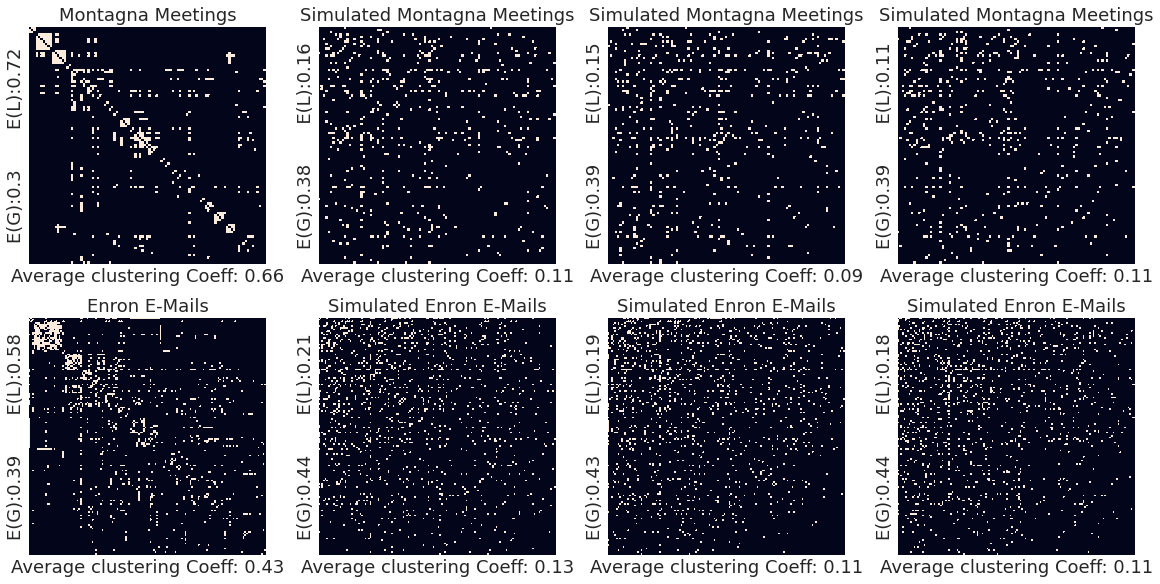

In [18]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fig, axs = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)

sns.heatmap(G1_adj, cbar=False, yticklabels=False, xticklabels=False, cmap="rocket", ax=axs[0, 0], square=True)
axs[0, 0].title.set_text("Montagna Meetings")
axs[0, 0].set_xlabel("Average clustering Coeff: " + str(np.round(nx.average_clustering(G1), 2)))
axs[0, 0].set_ylabel(f"E(G):{EG_G1[0]}       E(L):{EL_G1[0]}")

for i in range(1, 4):
    sns.heatmap(nx.to_numpy_matrix(G1_syn[i]), cbar=False, yticklabels=False, xticklabels=False, cmap="rocket", ax=axs[0, i], square=True)
    axs[0, i].title.set_text("Simulated Montagna Meetings")
    axs[0, i].set_xlabel("Average clustering Coeff: " + str(np.round(nx.average_clustering(G1_syn[i]), 2)))
    axs[0, i].set_ylabel(f"E(G):{EG_G1[i]}       E(L):{EL_G1[i]}")

    
    
sns.heatmap(G2_adj, cbar=False, yticklabels=False, xticklabels=False, cmap="rocket", ax=axs[1, 0], square=True)
axs[1, 0].title.set_text("Enron E-Mails")
axs[1, 0].set_xlabel("Average clustering Coeff: " + str(np.round(nx.average_clustering(G2), 2)))
axs[1, 0].set_ylabel(f"E(G):{EG_G2[0]}       E(L):{EL_G2[0]}")

for i in range(1, 4):
    sns.heatmap(nx.to_numpy_matrix(G2_syn[i]), cbar=False, yticklabels=False, xticklabels=False, cmap="rocket", ax=axs[1, i], square=True)
    axs[1, i].title.set_text("Simulated Enron E-Mails")
    axs[1, i].set_xlabel("Average clustering Coeff: " + str(np.round(nx.average_clustering(G2_syn[i]), 2)))
    axs[1, i].set_ylabel(f"E(G):{EG_G2[i]}       E(L):{EL_G2[i]}")

plt.show()

As it is stated before, Maslov-Sneppen algorithm preserves the node degree distribution and the number of edges across the graph, however, it cannot preserve the graph topology. Because edges are randomly distributed across all vertices of a graph, more clusterted graphs transform into a more uniformly distributed graph topology and core-peripheral structures are destroyed. 

### Conclusion

- After Maslov-Sneppen algorithm implementation, the general topology of a graph is changed dramatically, as a result; clusters are broken and efficiencies are affected. 
- Local and global efficiency metrics are correlated with clustering.
- If the graph topology is desired to be preserved, some other random graph generator methods can be applied for further studies, however, it is intuitively concluded that metric results will be similar if the random graphs are generated based on the same topology of an original or anchor graph. 


## 5. References

[1] Rostami, A., & Mondani, H. (2015). The complexity of crime network data: A case study of its consequences for crime control and the study of networks. PloS one, 10(3), e0119309.

[2] Arias-Castro, E., Candes, E. J., & Durand, A. (2011). Detection of an anomalous cluster in a network. The Annals of Statistics, 278-304.

[3] Ficara, A., Cavallaro, L., De Meo, P., Fiumara, G., Catanese, S., Bagdasar, O., & Liotta, A. (2019, December). Social network analysis of sicilian mafia interconnections. In International Conference on Complex Networks and Their Applications (pp. 440-450). Springer, Cham.

[4] https://laxmena.medium.com/the-unethical-story-enron-6a32ed82c9d3
